## Предсказание жилых зданий


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd

from floor_predictior.osm_living_predictor import (
    BoundaryFetcher, 
    BuildingProcessor,
    RoadProcessor,
    AmenityProcessor,
    FeatureBuilder,
    ModelHandler
    )

from floor_predictior.utils.IsLivingChecker import IsLivingAnnotator

In [ ]:
# Загрузка всех районов СПб (опционально). Можно указать любые подходящие osmid
# В результате вернется подготовленный файл с атрибутом `is_living` где это возможно

districts = [1114193, 1114252, 1114354, 1114806, 1114809, 337424, 1114895, 363103, 1115082, 1115366, 338636, 368287, 1114905, 367375, 1115367, 338635, 369514, 1114902] 
districts = [1327509,] # Загрузка одного района заняла ~2 минуты. Однако, опционально, по размеру полигона

parts = []

for district in districts:
    downloader = BoundaryFetcher()
    bounds = downloader.by_osmid(district, 'R')     # Wall time: 22.1 ms
    # Обработка
    tags_list = [
        'religious','recreation_ground',
        'residential','commercial',         
        'cemetery','construction',
        'farmland','farmyard',
        'forest','military'
        ]

    buildings = BuildingProcessor(bounds)
    buildings_gdf = buildings.load_buildings()      # Wall time: 10.1 s Кажется, здесь взял из кэша, но для первого раза 1.5-2 минут нужно
    lu = buildings.load_landuse()                   # Wall time: 720 ms
    merged_lu = buildings.merge_landuse(tags_list=tags_list) # Wall time: 176 ms
    rp = RoadProcessor(bounds=bounds, buildings=buildings_gdf, radius_list=[30, 60, 90])
    roads = rp.load_roads()                         # Wall time: 3.41 s
    rp._buffer_roads()                              # Wall time: 13.7 s  # можно не вызывать явно — вызовется из _join_buildings_to_buffers
    rp._join_buildings_to_buffers()                 # Wall time: 35.1 s
    features_df = rp.build_feature_table()          # Wall time: 81.2 ms

    ap = AmenityProcessor(bounds=bounds, base_gdf=features_df, radii=[30, 60, 90], local_crs=buildings.local_crs)
    feat_with_amenities = ap.run()                  # Wall time: 7.66 s

    # Признаки
    builder = FeatureBuilder(feat_with_amenities)
    data = builder.build_features()                 # Wall time: 97.5 ms
    

    annotator = IsLivingAnnotator(data, local_crs=buildings.local_crs, match_strategy="iou", iou_threshold=0.3)
    gdf_with_labels = annotator.annotate()          # Wall time: 12.8 s  # это копия gdf + колонка 'is_living'
    gdf_with_labels.to_crs(4326, inplace=True)

    parts.append(gdf_with_labels)

full_gdf = pd.concat(parts, ignore_index=True)
full_gdf = gpd.GeoDataFrame(full_gdf, geometry="geometry", crs=parts[0].crs)


In [3]:
full_gdf = pd.read_pickle("data/processed_data_spb.pkl")

In [4]:
data = full_gdf.copy()

In [5]:
data = data.select_dtypes(include=['number']).drop(columns=['id'])
data.dropna(inplace=True)

In [ ]:
# Создание модели
from sklearn.ensemble import RandomForestClassifier

external_model = RandomForestClassifier(random_state=42)
handler = ModelHandler("model/model_dt.pkl", df=data, target_col="is_living")
handler.set_model(external_model)

X_train, X_test, y_train, y_test = handler.train_test_split()
handler.train_model(X_train, y_train, save=True)

predicted = handler.predict(X_test, map_labels=True)


[CV] Accuracy: mean=0.9957, std=0.0004


In [6]:
predict_data = full_gdf[full_gdf['is_living'].isna()].copy()
predict_data = predict_data.select_dtypes(include=['number']).drop(columns=['id'])

In [7]:
# Загрузка модели

handler = ModelHandler("model/model_dt.pkl", df=predict_data, target_col="is_living")
handler.load_model_from_file()

predicted = handler.predict(predict_data, map_labels=False)

In [ ]:
predict_data['is_living'] = predicted['predicted']
# predict_data.to_pickle('processeed_data.pkl')

## Предсказание этажности


In [9]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from floor_predictior.osm_height_predictor.geo import (BuildingPreprocessor, 
                                GeometryFeatureGenerator, 
                                SpatialStatisticsComputer, 
                                SpatialNeighborhoodAnalyzer, 
                                StoreyModelTrainer)

In [10]:
# Define the folder path
folder_path = "data/"
pkl_files = [
    os.path.join(folder_path, f)
    for f in os.listdir(folder_path)
    if f.endswith(".pkl")
]

df_list = [pd.read_pickle(f).to_crs(4326) for f in pkl_files]
df_building = (
    pd.concat(df_list, ignore_index=True)
    .rename(columns={"building:levels": "storey"})
    .dropna(subset=["storey"])
    .select_dtypes(exclude=['object', 'string'])
    .drop(columns=['id'])
)

df_building["storey"] = df_building["storey"].astype(int)

df_building = df_building[df_building["is_living"] == 1].reset_index(drop=True)
df_building = df_building[(df_building["storey"] > 2)]

In [11]:
# 1. Предобработка
prep = BuildingPreprocessor(df_building)
prep.filter_residential()
df = prep.get()

In [12]:
# 2. Геометрические признаки
geo_gen = GeometryFeatureGenerator(df)
df = geo_gen.compute_geometry_features()

In [13]:
# 3. Пространственный анализ
stats = SpatialStatisticsComputer(df)
df, global_moran, lisa = stats.compute_moran_and_lisa(col="storey")

In [16]:
# 4. Соседние признаки
analyzer = SpatialNeighborhoodAnalyzer(df)
df, artifacts = analyzer.compute_neighborhood_metrics(plot=False)

Neighborhood stats: 100%|██████████| 19153/19153 [00:21<00:00, 910.07it/s] 


In [ ]:
# 5. Обучение модели
trainer = StoreyModelTrainer(df)
X_train, X_test, y_train, y_test = trainer.prepare_data()
param_dist = {"n_estimators": [100]} # Можно не передавать, есть базовый словарь. Это мини-версия для проверки работы
model = trainer.train_rf(X_train, y_train, param_dist=param_dist)

In [20]:
y_pred = trainer.predict(X_test)

## Plot

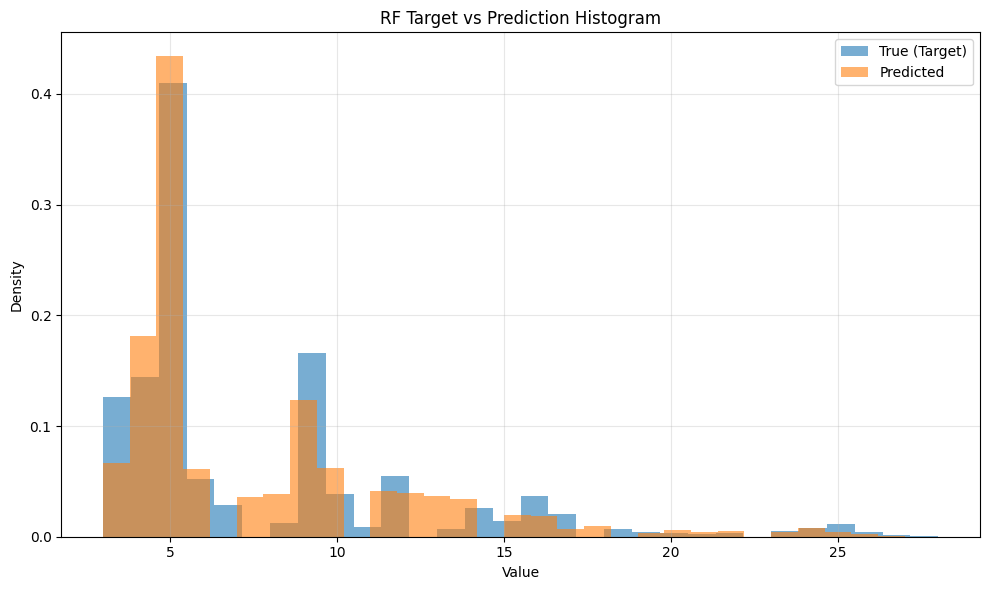

In [21]:
import numpy as np

b_gem = df.to_crs(3857).centroid.copy()

def plot_target_vs_prediction(
    y_true, y_pred, bins=30, title="RF Target vs Prediction Histogram"
):
    plt.figure(figsize=(10, 6))
    plt.hist(y_true, bins=bins, alpha=0.6, label="True (Target)", density=True)
    plt.hist(y_pred, bins=bins, alpha=0.6, label="Predicted", density=True)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_target_vs_prediction(y_test, np.round(y_pred))

In [ ]:
import matplotlib.pyplot as plt

# Count occurrences of each (true, predicted) pair
counts = df_building.groupby(["storey", "pred_storey"]).size().reset_index(name="count")
import matplotlib.pyplot as plt
import numpy as np

# Normalize counts for bubble size (square root scaling helps perception)
counts["size"] = counts["count"] / 2  # tweak factor 30 as needed

plt.figure(figsize=(10, 7))
sc = plt.scatter(
    counts["storey"],
    counts["pred_storey"],
    s=counts["size"],
    alpha=0.3,
    c=np.log(counts["count"]),
    cmap="Blues",
    edgecolor="black",
    linewidth=0.8,
)

plt.plot(
    [df_building["storey"].min(), df_building["storey"].max()],
    [df_building["storey"].min(), df_building["storey"].max()],
    linestyle="--",
    color="red",
    label="Ideal (y = x)",
)

plt.xlabel("True number of storeys")
plt.ylabel("Predicted number of storeys")
plt.title("Predicted vs. True Storeys")
cbar = plt.colorbar(sc)
cbar.set_label("Log frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from libpysal.weights import KNN
import geopandas as gpd

def analyze_residuals(gdf, true_col="storey", pred_col="pred_storey", k=10):
    """
    Analyzes spatial autocorrelation in model residuals
    """
    from esda.moran import Moran
    from libpysal.weights import KNN
    import matplotlib.pyplot as plt
    from splot.esda import plot_moran

    # Calculate residuals
    gdf["residuals"] = gdf[true_col] - gdf[pred_col]

    # Create spatial weights
    w = KNN.from_dataframe(gdf, k=k)
    w.transform = "r"

    # Calculate Moran's I for residuals
    moran = Moran(gdf["residuals"], w)

    print(f"\nResidual Analysis:")
    print(f"Moran's I: {moran.I:.4f}")
    print(f"p-value: {moran.p_sim:.4f}")

    # Plot Moran scatter plot
    fig, ax = plt.subplots(figsize=(12, 3))
    plot_moran(moran, zstandard=True)
    plt.title("Moran's I Scatter Plot for Model Residuals")
    plt.tight_layout()
    plt.show()

    return moran


# After model training, analyze residuals
moran_residuals = analyze_residuals(
    gpd.GeoDataFrame(df_building.join(b_gem.rename("geometry"), how="inner")),
    true_col="storey",
    pred_col="pred_storey",
    k=10,
)


In [ ]:
def plot_error_map(df, true_col="storey", pred_col="pred_storey"):
    """
    Plots a map showing prediction errors for building heights.
    Colors indicate if predictions are within ±20% of true values.
    'Within ±20%' predictions are shown with a glass-like transparency effect.
    """
    # Convert to GeoDataFrame if not already
    gdf = gpd.GeoDataFrame(df) if not isinstance(df, gpd.GeoDataFrame) else df

    # Calculate relative errors
    gdf["rel_error"] = round((gdf[pred_col] - gdf[true_col]) / gdf[true_col], 2)
    gdf["error"] = round(gdf[pred_col] - gdf[true_col], 2)

    # Create error categories
    conditions = [
        (gdf["rel_error"] < -0.15) & (np.abs(gdf["error"]) > 2),
        (gdf["rel_error"] > 0.15) & (np.abs(gdf["error"]) > 2),
        (gdf["rel_error"].between(-0.15, 0.15)),
    ]
    choices = ["Underprediction >15%", "Overprediction >15%", "Within ±15%"]
    gdf["error_category"] = np.select(conditions, choices, default="Within ±15%")

    # Create color mapping with transparency
    color_dict = {
        "Underprediction >15%": "red",
        "Overprediction >15%": "blue",
        "Within ±15%": "#7fcdbb",  # Light blue-green for glass effect
    }

    alpha_dict = {
        "Underprediction >15%": 0.7,
        "Overprediction >15%": 0.7,
        "Within ±15%": 0.3,  # More transparent for glass effect
    }

    # Create the plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    # Plot background layer first (all buildings with very light color)
    gdf.plot(color="lightgray", alpha=0.1, ax=ax)

    # Plot with categorical colors - plot good predictions first
    categories = ["Within ±15%", "Underprediction >15%", "Overprediction >15%"]
    for category in categories:
        mask = gdf["error_category"] == category
        if mask.any():
            gdf[mask].plot(
                color=color_dict[category],
                ax=ax,
                label=category,
                alpha=alpha_dict[category],
                edgecolor="white" if category == "Within ±15%" else "none",
                linewidth=0.5 if category == "Within ±15%" else 0,
                markersize=2,
            )

    # Customize the plot
    ax.set_title("Building Height Prediction Errors", pad=20)
    ax.axis("off")

    # Customize legend
    ax.legend(
        title="Prediction Accuracy", frameon=True, framealpha=0.9, edgecolor="white"
    )

    plt.tight_layout()
    plt.show()

    return gdf


# Use the function
gdf = plot_error_map(df_building.join(b_gem.rename("geometry"), how="inner"))


In [ ]:
gdf["abs_error"] = np.abs(gdf["storey"] - gdf["pred_storey"])
gdf["abs_error"] = gdf["abs_error"].round(3)

gdf["abs_rel_error"] = gdf["abs_error"] / (gdf["storey"] + 1e-6)
gdf["abs_rel_error"] = gdf["abs_rel_error"].round(3)

gdf.loc[
    (gdf["abs_error"] < 5) & (gdf["storey"] > 15),
    list(gdf.columns[-6:])
    + [
        "storey",
        "pred_storey",
        "cluster_High-High",
        "cluster_High-Low",
        "cluster_Low-High",
        "cluster_Low-Low",
        "storey_lag",
    ],
].explore(
    "abs_rel_error",
    tiles="CartoDB positron",
    style_kwds={"fillOpacity": 0.5},
    colormap="RdYlGr",
    legend=True,
    name="Prediction Errors",
)
